O objetivo deste notebook é classificar a minha presença e/ou a presença da minha esposa nas fotos do nosso casamento.
Treinamos uma rede convolucional, com Keras, para fazer a classificação.

### Multilabel Classification com Keras

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

import re
import os
import cv2 as cv

2023-02-27 15:37:05.122189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_19_9:
2023-02-27 15:37:05.122209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Importa dados

In [2]:
BATCH_SIZE = 32

# Entrada da rede e tamanho das imagens
input_shape = (160, 160, 3)

In [3]:
def structure_images(path_to_subset):
    
    # Listas pra salvar as imagens e rotulos
    X = []
    Y = []

    # Itera sobre as classes no diretorio
    for folder in os.listdir(path_to_subset):

        # Le as imagens da classe e carrega em X e Y
        for image in os.listdir(os.path.join(path_to_subset, folder)):
            path_to_image = os.path.join(path_to_subset, folder, image)
            image = cv.imread(path_to_image)    
            image = cv.resize(image, (input_shape[0], input_shape[1]))
            label = [folder]
            if '_' in folder:
                label = folder.split('_')

            X.append(image)
            Y.append(label)

    X = np.array(X)
    Y = np.array(Y)
    
    return(X, Y)

In [4]:
x_train, y_train = structure_images('./rostos/train')

/tmp/ipykernel_226558/4285378919.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


In [5]:
x_val, y_val = structure_images('./rostos/validation')

/tmp/ipykernel_226558/4285378919.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


#### Formata rotulos pra classificacal multilabel

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train, shuffle = True, random_state=3)

In [8]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1755, 160, 160, 3) (1755, 2)
(642, 160, 160, 3) (642, 2)


#### Formata dados

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

2023-02-27 15:37:21.861398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dshome/venv/lib/python3.8/site-packages/cv2/../../lib64:/opt/oracle/instantclient_19_9:
2023-02-27 15:37:21.861422: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-27 15:37:21.861435: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ec2-sa1-1b-p-analetslytics-dev): /proc/driver/nvidia/version does not exist
2023-02-27 15:37:21.861671: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the 

In [10]:
train_dataset = train_dataset.batch(BATCH_SIZE).repeat().prefetch(1)
val_dataset = val_dataset.batch(BATCH_SIZE).repeat().prefetch(1)

#### Modela rede

In [11]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(input_shape[0], input_shape[1]),
    layers.Rescaling(1./255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout

model = Sequential()

model.add(resize_and_rescale)
model.add(data_augmentation)

model.add(Conv2D(16, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

# model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(3))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(mlb.classes_), activation = 'sigmoid'))

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Checkpoint pra salvar o melhor modelo
checkpoint = ModelCheckpoint('../working/best_model.hdf5', save_best_only = True, monitor = 'val_loss')
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

optimizer = Adam() 
model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    
    validation_data = val_dataset,
    validation_steps=len(x_val) // BATCH_SIZE,
    
    epochs = 80, 
    callbacks = [checkpoint, early_stopping],
)

Epoch 1/80
54/54 [==============================] - 10s 161ms/step - loss: 0.8505 - accuracy: 0.6019 - val_loss: 0.4650 - val_accuracy: 0.3078
Epoch 2/80
54/54 [==============================] - 8s 156ms/step - loss: 0.6721 - accuracy: 0.6274 - val_loss: 0.4824 - val_accuracy: 0.5172
Epoch 3/80
54/54 [==============================] - 8s 156ms/step - loss: 0.5799 - accuracy: 0.6465 - val_loss: 0.4885 - val_accuracy: 0.4156
Epoch 4/80
54/54 [==============================] - 8s 157ms/step - loss: 0.5121 - accuracy: 0.6750 - val_loss: 0.4470 - val_accuracy: 0.6313
Epoch 5/80
54/54 [==============================] - 8s 157ms/step - loss: 0.4644 - accuracy: 0.6628 - val_loss: 0.4551 - val_accuracy: 0.6062
Epoch 6/80
54/54 [==============================] - 8s 157ms/step - loss: 0.4100 - accuracy: 0.6883 - val_loss: 0.3815 - val_accuracy: 0.5641
Epoch 7/80
54/54 [==============================] - 8s 157ms/step - loss: 0.3807 - accuracy: 0.6790 - val_loss: 0.3577 - val_accuracy: 0.4313
Epoch

#### Plota dados do treino

<AxesSubplot:>

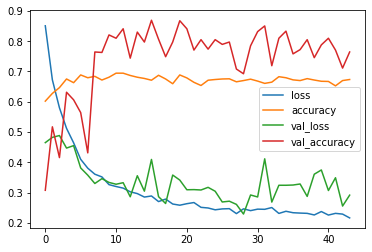

In [16]:
# Plot os resultados do treino
pd.DataFrame(history.history).plot()

#### Carrega melhor modelo

In [17]:
# Load do melhor modelo
model.load_weights('../working/best_model.hdf5')

# Salva o modelo par ausar depois
model.save('../working/model.hdf5')

#### Avalia modelo no teste

In [18]:
from sklearn.metrics import multilabel_confusion_matrix

# Classifica observacoes de teste
def predict_labels(model, x_test):
    preds = model.predict(x_test)
    preds = np.where(preds < 0.5, 0, 1)
    return(preds)

preds = predict_labels(model, x_test)

# Cria matriz de confusao
confusion = multilabel_confusion_matrix(y_test, preds)
confusion

array([[[ 37,  20],
        [  1, 138]],

       [[  6,  13],
        [  0, 177]]])

In [19]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, preds, average='micro')

(0.9051724137931034, 0.9968354430379747, 0.9487951807228916, None)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

0.826530612244898

#### Mostra imagens com classe real e prevista

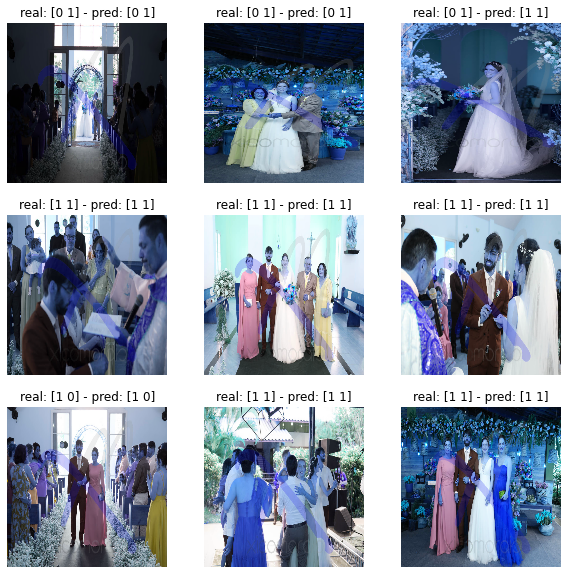

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[i])
    plt.title('real: ' + str(y_test[i])+ " - pred: "+ str(preds[i]))
    plt.axis("off")
plt.show()